# Empirical Validation I

In [1]:
import os
path_folder=r'C:\Users\Borsti\Desktop\Thesis\Code\Benessen vs Roemer\rbergomi'
os.chdir(path_folder)

from datetime import datetime, timedelta
from datetime import datetime as dt

import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from rbergomi import rBergomi
import pandas as pd
import pickle
import pytz
from requests_html import HTMLSession
import scipy
import time
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
#% matplotlib inline

import NeuralNetworkPricing as nnp
import matplotlib.pyplot as plt 

import pandas_datareader.data as web
import scipy
import yfinance as yf

from yahoo_fin.options import get_options_chain, get_expiration_dates

In [2]:
def forward_price(spot, div, r, tau):
    """
    Input:
    spot = Spot Price
    div = sum of dividends to be paid until expiration of option contract at T
    r = Risk free rate
    tau = Time to Expiration (can be single number or array)
    
    Output:
    Forward Price F
    
    Computes the forward price, allows for single or array input
    """
    
    F = spot*np.exp(r*tau) - div*np.exp(r*tau)
    return F

In [3]:
def str_to_float(value):
    try:
        return np.float(value)
    except ValueError as ve:
        #print("value error: {}".format(ve))
        try:
            sepvals=value.split(",")
            fixed_val = np.float((sepvals[0])+(sepvals[1]))
            return fixed_val
        except Exception as e:
            #print("Normal exception: {}".format(e))
            pass
        
    except Exception as e:
        #print("Normal exception: {}".format(e))
        pass
vec_stf = np.vectorize(str_to_float)
    
def get_earnings_data(ticker):
    
    # Parse yahoo finance & scrape earnings data
    url = "https://finance.yahoo.com/calendar/earnings?symbol={}".format(ticker)
    session = HTMLSession()
    resp = session.get(url)
    html = resp.html.raw_html.decode()
    earnings_table = pd.read_html(html)[0]
    
    # Convert Data to readable format
    reported_values = [str_to_float(x) for x in earnings_table["Reported EPS"]]
    estimated_values = [str_to_float(x) for x in earnings_table["EPS Estimate"]]
    surprise_values = [str_to_float(x) for x in earnings_table["Surprise(%)"]]
    str_earnings = "%b %d, %Y, %I %p"
    datetime_data = [datetime.strptime(x[:-3], str_earnings) for x in earnings_table["Earnings Date"]]
    earnings_table["Reported EPS"] = reported_values
    earnings_table["EPS Estimate"] = estimated_values    
    earnings_table["Surprise(%)"] = surprise_values 
    earnings_table["Earnings Date"] = datetime_data
    return earnings_table

def price_div_hist_fun(ticker, date_str):
    # define ticker and get data
    ticker_object = yf.Ticker(ticker)
    price_div_hist = ticker_object.history(start='2010-01-01')
    # get spot
    close_price = price_div_hist['Close']
    spot = float(close_price[close_price.index==date_str])
    return spot, price_div_hist 
    
def dividend_estimation(ticker, year, date_str):
    
    earnings_table = get_earnings_data(ticker)
    _, price_div_hist = price_div_hist_fun(ticker, date_str)
    
    # Specify time range of dividend payments
    
    # calculate dividend payout ratio
    earnings_table_year = earnings_table[ ( earnings_table["Earnings Date"]> str(year)) & ( earnings_table["Earnings Date"] < str(year+1)) ]
    price_div_hist_year = price_div_hist[(price_div_hist.index > str(year)) & (price_div_hist.index < str(year+1))]
    
    cum_earnings = earnings_table_year["Reported EPS"].sum()
    cum_dividends = price_div_hist_year["Dividends"].sum()

    dividend_payout_ratio = cum_dividends/cum_earnings
        
    # unique years
    data = df_all_maturities["Maturity"]
    str_mat = "%B %d, %Y"
    list1 = [datetime.strptime(x, str_mat) for x in data]
    unique_years = set([x.year for x in list1])
    
    # Projected Dividends
    projected_earnings = earnings_table[earnings_table["Earnings Date"]>str(year+1)]
    projected_dividends = projected_earnings["EPS Estimate"]*dividend_payout_ratio
    projected_earnings.loc[:,"Div Estimate"] = projected_dividends
    
    # combining past and projected dividends
    div_hist_df = pd.DataFrame(index=price_div_hist.index)
    div_hist_df["Dividends"] = price_div_hist.Dividends
    div_est_df = pd.DataFrame(index=projected_earnings["Earnings Date"])
    div_est_df["Dividends"] = projected_earnings["Div Estimate"].values
    all_div_df = pd.concat([div_hist_df, div_est_df])
    return all_div_df
    
def find_pv_dividends(date_str, df_all_maturities, all_div_df, r):
    str_today = "%Y-%m-%d"
    today_dt = datetime.strptime(date_str, str_today)
    pv_dividend_list = list()

    for index0, row0 in df_all_maturities.iterrows():
        # Finding all (dividend) dates between time of observation and option chain maturity! 
        data_df = all_div_df[ (all_div_df.index > date_str) & (all_div_df.index < row0["Maturity"]) ]
        data_df.loc[:,"PV_dividends"] = np.zeros(len(data_df.index))

        # If no dividend payments fall within timeframe, do nothing
        div_sum = data_df.values.sum()
        if div_sum == 0: 
            sum_pv_dividends = 0
        # if there are dividend payments...
        else:
            # for each dividend payment
            for index, row in data_df.iterrows():
                divPayment = row["Dividends"]

                if not divPayment == 0:

                    time_in_years = (index - today_dt).days/252

                    row["PV_dividends"] = divPayment * np.exp(-r*time_in_years)

        sum_pv_dividends = data_df["PV_dividends"].sum()
        pv_dividend_list.append(sum_pv_dividends)
    df_all_maturities["PV Dividends"] = pv_dividend_list
    return df_all_maturities

#spot, _ = price_div_hist_fun(ticker, date_str)
#all_div_df = dividend_estimation(ticker, year, date_str)
#df_all_maturities = find_pv_dividends(date_str, df_all_maturities, all_div_df, r)   

In [4]:
def rbergomi_s(forward, strikes, texp, params):
    
    """
    Input: 
    forward = Forward Price
    strikes = Set of Strike prices for one(!) expiration
    texp = Time to Expiration
    params = rBergomi Parameters
    
    Output:
    rBivs = rBergomi IVs
    call_prices = rBergomi computed call prices
    rB = rBergomi model object
    FT = 20.000 Forward Price adjusted price realizations at T
    
    This function is able to compute the rBergomi IVs and other values for a single(!)
    expiration
    
    """
    
    alpha, eta, rho, xi = params
    
    # to ensure computation works, we have to give greater granularity for very short durations.
    if texp < 0.01:
        steps_year = 100000
    else:
        steps_year = 366

    # Defining the Fractional Brownian Process and Resulting Price Process
    np.random.seed(4)
    rB = rBergomi(n = steps_year, N = 20000, T = texp, a = alpha)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho = rho)
    V = rB.V(Y, xi = xi, eta = eta)
    S = rB.S(V, dB)
    
    # rBergomi Implied Volatilities and Call Prices
    ST = S[:,-1][:,np.newaxis]
    FT = ST*forward
    K = strikes #np.exp(strikes) #(np.exp(k)*spot)[np.newaxis,:]
    call_payoffs = np.maximum(FT - K,0)
    call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
    rBivs = vec_bsinv(call_prices, forward, np.transpose([K]), rB.T)
    return rBivs, call_prices, rB, FT

In [208]:
def calculating_expiration(file_name, expiration_dates, loaded_dictionary):
    """
    Input:
    file_name = file name of loaded option data in pickle format
    expiration_dates = extracted dates of maturities for option data 
    loaded_dictionary = all available option data
    
    Output:
    df_all_maturities = dataframe of all option data
    t_datetime = time of observation in datetime format
    
    Calculating all expirations of option chain in years and 
    combining all information into one DataFrame!
    """
    
    # Time of File
    date_str = file_name.split("_")[-1][:-4]
    str_format1 = "%Y-%m-%d"
    t_datetime = datetime.strptime(date_str, str_format1)


    df_all_maturities = pd.DataFrame()
    for i, val in enumerate(expiration_dates):

        # Time To Expiration
        str_format2 = "%B %d, %Y"
        exp_datetime = datetime.strptime(val, str_format2)

        # Calculating Time to Expiration in Years
        totsec = (exp_datetime - t_datetime).total_seconds()
        years = totsec / 3600 / 24 / 365
        tau = np.round(years, 3)
        
        # Storing all info in the dataframe
        df_maturity_t = loaded_dictionary[val]["calls"]
        df_maturity_t["Maturity"] = val
        df_maturity_t["Tau"] = tau
        df_all_maturities = pd.concat([df_all_maturities, df_maturity_t])
    return df_all_maturities, t_datetime

def clean_contracts(df, t_datetime):
    """
    Input:
    df = dataframe of all option data
    t_datetime = time of observation in datetime format
    
    Output:
    df_clean = dataframe of cleaned data by liquidity and time of last trade
    df_unclean = dataframe with both liquid (clean) and illiquid (unclean) data
    
    Cleans the observed contracts according to liquidity and time of last price
    
    """
    
    df2 = df.copy()
    
    str_format2 = "%B %d, %Y"
    exp_datetime_list = [datetime.strptime(x, str_format2) for x in df2["Maturity"].values]
    
    # calculate needed data
    df2["Ask"] = vec_stf(df2["Ask"])
    df2["Bid"] = vec_stf(df2["Bid"])
    mid = (df2["Ask"] + df2["Bid"])/2
    spread = df2["Ask"] - df2["Bid"]
    liquidity = spread/mid
    df2["Mid"] = mid
    df2["Spread"] = spread
    df2["Liquidity"] = liquidity
    df2["Keep"] = True
    
    # Calculate forward price for all contracts
    fwd_list = forward_price(spot, df2["PV Dividends"], r, df2["Tau"])
    df2.loc[:, "Fwd"] = fwd_list
    
    # Transform the reported IVs into usable float format
    yahoo_ivs = [str_to_float(x.split("%")[0])*0.01 for x in df2["Implied Volatility"].values]
    df2.loc[:, "Implied Volatility"] = yahoo_ivs
    
    # Translate reported date into python timestamp
    dt_str_list = [x.split(" ")[0] for x in df2["Last Trade Date"]]
    listasts = pd.DatetimeIndex(dt_str_list)
    df2["Last Trade Date"] = listasts
    df2 = df2.reset_index(drop=True)
    
    # Iterate through the df
    for index, row in df2.iterrows():

        # Identify too old trades/quotes
        date = row["Last Trade Date"]
        lasttrade_delta = (t_datetime - date).days
        if lasttrade_delta >= 1: # if last trade is older than 1 day

            delta_percent = lasttrade_delta/(exp_datetime_list[index] - date).days
            #print("need to check: ", lasttrade_delta)
            #print("delta: ", delta_percent)
            if delta_percent > 0.05:
                keep_var = False
            else:
                keep_var = True

        else:
            keep_var = True
            
        if keep_var == True:
            # Identify illiquid option contracts, for all that have been traded recently
            
            liquidity_i = row["Liquidity"]
            #print(liquidity_i)
            #print("liquidity: ", liquidity_i)
            if liquidity_i > 0.05 or liquidity_i < 0:
                keep_var = False
                #print("Keep?", keep_var)
            else:
                keep_var = True
                
            #print(liquidity_i, keep_var)
        df2.loc[index,"Keep"] = keep_var
    
    # Lastly drop all rows that have a no bid or ask information
    df2.loc[df2['Bid'] == 0, 'Keep'] = False
    df2.loc[df2['Ask'] == 0, 'Keep'] = False
    
    # Switch from unclean to clean data
    df_unclean = df2
    df_clean = df_unclean[df_unclean["Keep"]==True]
    
    cleaned_num = len(df) - len(df_clean)
    print("Number of deleted contracts: ", cleaned_num)
    return df_clean, df_unclean

In [209]:
file_loc = r"C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi\option_data"
ticker_list = ["AAPL", "GME", "MSFT", "NIO", "SPY", "T", "TSLA"]
ticker= ticker_list[6]
df_cleaned_all = pd.DataFrame()


#for ticker in ticker_list:
print("---------------")
print(ticker)
file_name =  "\optionsData_{}_2021-08-05.pkl".format(ticker)


date_str = file_name.split("_")[-1][:-4]
str_format1 = "%Y-%m-%d"
t_datetime = datetime.strptime(date_str, str_format1)

file_to_read = open(file_loc + file_name, "rb")
loaded_dictionary = pickle.load(file_to_read)
expiration_dates = [key for key in loaded_dictionary]

#Get Spot information
time.sleep(25)
spot, _ = price_div_hist_fun(ticker, date_str)

# Download Discount Rate for black scholes models
start = dt(2010, 1, 1)
end = dt.today()
# DFF = https://fred.stlouisfed.org/series/DFF
# Effective federal funds rate
eff = web.DataReader("DFF", "fred", start, end) # in percent
r = eff.loc[date_str].DFF * 0.01 # in decimal places

"""
Here we calculate 
- the dataframe of only illiquid contracts
- BID/ASK/MID IVs
- Log Strike
- Log Moneyness

"""


# Combining all contracts for all maturities into one df
df_all_maturities, t_datetime = calculating_expiration(file_name, expiration_dates, loaded_dictionary)

# Add Dividend Information to df_all_maturities
year = 2021 # this sets the year for which dividend payout ratio is defined
all_div_df = dividend_estimation(ticker, year, date_str)
df_all_maturities = find_pv_dividends(date_str, df_all_maturities, all_div_df, r)   

# Cleaning the contracts
df_cleaned, df_uncleaned = clean_contracts(df_all_maturities, t_datetime)

# Dataframe of discarded option contracts
df_not_clean = df_uncleaned[~df_uncleaned.apply(tuple,1).isin(df_cleaned.apply(tuple,1))]

# As python is not able to compute the IVs within the functions above (potential bug?)
# we simply add those here:

# Finding BID/ASK/MID IVs for all contracts
try:
    bid_iv_vals = vec_bsinv(df_cleaned["Bid"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
    ask_iv_vals = vec_bsinv(df_cleaned["Ask"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
    mid_iv_vals = vec_bsinv(df_cleaned["Mid"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
except Exception as e:
    print(e)
    bid_iv_vals = list()
    ask_iv_vals = list()
    mid_iv_vals = list()
    for index, row in df_cleaned.iterrows():
        try:
            bid_iv_vals.append(bsinv(row["Bid"], row["Fwd"], row["Strike"], row["Tau"]))
        except Exception as e:
            bid_iv_vals.append(np.nan)
        try:
            ask_iv_vals.append(bsinv(row["Ask"], row["Fwd"], row["Strike"], row["Tau"]))
        except Exception as e:
            ask_iv_vals.append(np.nan)
        try:
            mid_iv_vals.append(bsinv(row["Mid"], row["Fwd"], row["Strike"], row["Tau"]))
        except Exception as e:
            mid_iv_vals.append(np.nan)




df_cleaned.loc[:, "Bid IVs"] = bid_iv_vals
df_cleaned.loc[:, "Ask IVs"] = ask_iv_vals
df_cleaned.loc[:, "Mid IVs"] = mid_iv_vals

# ------------------- This step is to take the yahoo reported IVs, whenever the MID IVs report erroneous values --------------------------------------------
mid_vols = df_cleaned["Mid IVs"].values
# This is a 1D array of true/false values given the condition at the end
condition=np.mod(mid_vols, 1)==1e-19
#this extracts the values from yahooivs, where mid-vols are close to zero
extractedvals = np.extract(condition, df_cleaned["Implied Volatility"].values)
# this inserts the yahoo ivs, in case the mid vols are close to zero in the correct position
np.place(mid_vols, mid_vols == 1e-19, extractedvals)

df_cleaned.loc[:, "Mid IVs"] = mid_vols
# ----------------------------------------------------------------------------------------------------------------------------------------------------------



# set log-strike column
log_strike = np.log(df_cleaned["Strike"]/df_cleaned["Fwd"])
df_cleaned.loc[:, "Log Strike"] = log_strike

# set log-moneyness column
log_moneyness = np.log(df_cleaned["Fwd"]/df_cleaned["Strike"])
df_cleaned.loc[:, "Log Moneyness"] = log_moneyness

# Set Ticker column
df_cleaned.loc[:,"Ticker"] = ticker

df_cleaned_all = pd.concat([df_cleaned_all, df_cleaned])


---------------
TSLA


C:\Users\Borsti\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Borsti\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Borsti\anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Number of deleted contracts:  1645
f(a) and f(b) must have different signs


In [210]:
df_cleaned_all.iloc[:,10:]

,Implied Volatility,Maturity,Tau,PV Dividends,Mid,Spread,Liquidity,Keep,Fwd,Bid IVs,Ask IVs,Mid IVs,Log Strike,Log Moneyness,Ticker
0,5.0313,"August 6, 2021",0.003,0.0,414.550,1.30,0.003136,True,714.632149,1.000000e-19,6.797961,5.031300,-0.867985,0.867985,TSLA
1,4.8555,"August 6, 2021",0.003,0.0,404.550,1.30,0.003213,True,714.632149,1.000000e-19,6.558729,4.855500,-0.835196,0.835196,TSLA
2,4.6836,"August 6, 2021",0.003,0.0,394.550,1.30,0.003295,True,714.632149,1.000000e-19,6.327100,4.683600,-0.803447,0.803447,TSLA
3,4.5176,"August 6, 2021",0.003,0.0,384.550,1.30,0.003381,True,714.632149,1.000000e-19,6.102568,4.517600,-0.772675,0.772675,TSLA
10,3.4766,"August 6, 2021",0.003,0.0,314.550,1.30,0.004133,True,714.632149,1.000000e-19,4.695546,3.476600,-0.580303,0.580303,TSLA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958,0.5834,"June 16, 2023",1.863,0.0,226.500,5.00,0.022075,True,715.962602,5.745081e-01,0.588547,0.581521,-0.022548,0.022548,TSLA
2959,0.5813,"June 16, 2023",1.863,0.0,215.375,8.15,0.037841,True,715.962602,5.683269e-01,0.590721,0.579507,0.019417,-0.019417,TSLA
2960,0.5812,"June 16, 2023",1.863,0.0,208.725,8.55,0.040963,True,715.962602,5.678378e-01,0.591048,0.579425,0.046445,-0.046445,TSLA
2966,0.5772,"June 16, 2023",1.863,0.0,142.250,1.50,0.010545,True,715.962602,5.741544e-01,0.578004,0.576079,0.334127,-0.334127,TSLA


# Neural Network Calibration

## Looking at data

Num of Observations: 1330


,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,...,Spread,Liquidity,Keep,Fwd,Bid IVs,Ask IVs,Mid IVs,Log Strike,Log Moneyness,Ticker
0,TSLA210806C00300000,2021-08-05,300.0,415.60,413.9,415.2,5.85,+1.43%,1,18,...,1.3,0.003136,True,714.632149,1.000000e-19,6.797961,5.0313,-0.867985,0.867985,TSLA
1,TSLA210806C00310000,2021-08-05,310.0,404.00,403.9,405.2,4.55,+1.14%,2,24,...,1.3,0.003213,True,714.632149,1.000000e-19,6.558729,4.8555,-0.835196,0.835196,TSLA
2,TSLA210806C00320000,2021-08-05,320.0,393.50,393.9,395.2,-8.84,-2.20%,2,12,...,1.3,0.003295,True,714.632149,1.000000e-19,6.327100,4.6836,-0.803447,0.803447,TSLA
3,TSLA210806C00330000,2021-08-05,330.0,384.00,383.9,385.2,-8.37,-2.13%,1,30,...,1.3,0.003381,True,714.632149,1.000000e-19,6.102568,4.5176,-0.772675,0.772675,TSLA
10,TSLA210806C00400000,2021-08-05,400.0,316.07,313.9,315.2,3.37,+1.08%,4,18,...,1.3,0.004133,True,714.632149,1.000000e-19,4.695546,3.4766,-0.580303,0.580303,TSLA


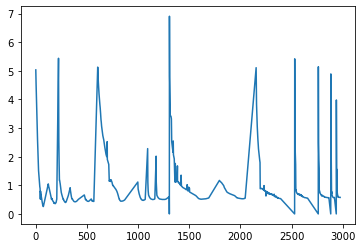

In [211]:
# Here we want to select the ticker 1 by 1 to avoid a mess
ticker_select = ticker
data_for_ticker_df = df_cleaned_all[df_cleaned_all["Ticker"]==ticker_select]
plt.plot(data_for_ticker_df["Implied Volatility"])
print("Num of Observations: {}".format(len(data_for_ticker_df)))
display(data_for_ticker_df.head())

## Prepare available Contract Grid

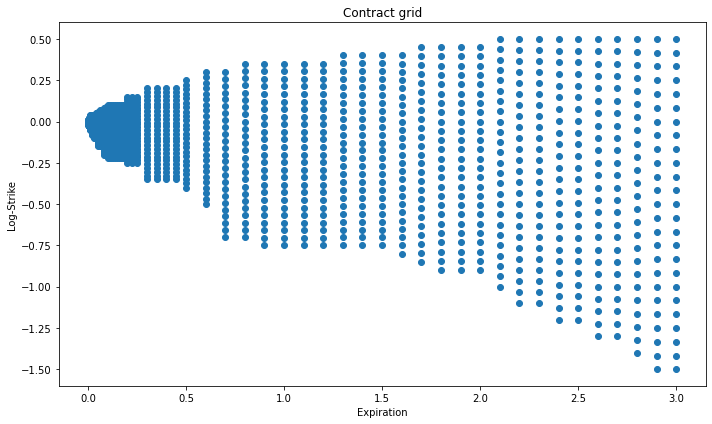

In [212]:
weights_folder = path_folder + "\\roemer_weights_rbergomi"
contracts_folder = path_folder + "\\roemer_contracts"


# Define neural network based (rough Bergomi) model:
model = nnp.NeuralNetworkPricer(contracts_folder,weights_folder,"rbergomi")

# Plot the neural network contract grid:

plt.figure(figsize=(10, 6))
plt.scatter(model.T,model.k)
plt.title("Contract grid")
plt.xlabel("Expiration")
plt.ylabel("Log-Strike")
plt.tight_layout()
plt.show()

## Prepare Neural Network

In [213]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(4)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

Original number of observations:  1330
After filtering: 460


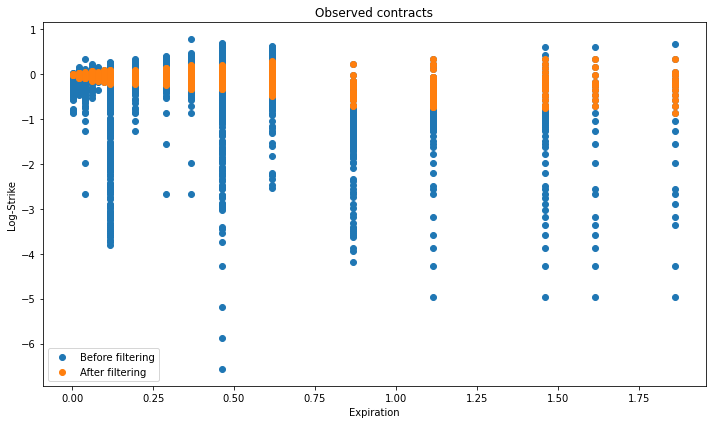

Optimisation message:  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
[True , Calibrated]: 
[[ 1.00000000e-06]
 [ 3.34003546e+00]
 [-9.99999000e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]
 [ 3.91563589e-01]]


In [215]:
# Load example contracts:
k_orig = np.transpose([data_for_ticker_df["Log Strike"]])# tmp[:,0].reshape(-1,1)
T_orig = np.transpose([data_for_ticker_df["Tau"]])# tmp[:,1].reshape(-1,1)

# Filter contracts that are not within the neural network domain:
idxKeep = model.AreContractsInDomain(k_orig,T_orig)
k_obs = np.flip(k_orig[idxKeep,:])
T_obs = np.flip(T_orig[idxKeep,:])


print("Original number of observations: ",len(k_orig))
print("After filtering:",len(k_obs))

# Plot contracts before and after filtering:
plt.figure(figsize=(10, 6))
plt.scatter(T_orig,k_orig,label="Before filtering")
plt.scatter(T_obs,k_obs,label="After filtering")
plt.title("Observed contracts")
plt.xlabel("Expiration")
plt.ylabel("Log-Strike")
plt.legend()
plt.tight_layout()
plt.show()



# Parameters as in Benessen
H_roemer = 0.1
eta_roemer = 1.9
rho_roemer = -0.15
xi_roemer = 0.05
parTrue = np.append(np.array([H_roemer,eta_roemer,rho_roemer]),(pow(xi_roemer,2))*np.ones((1,27))).reshape(30,1)

# Calculating Implied Volatilites via Black Scholes, as TRUE Implied Volatilities
#list of strikes after filtering
iv_obs = np.flip(data_for_ticker_df["Mid IVs"].values[idxKeep])
iv_obs = np.transpose([iv_obs])

# apply filtering to other relevant data
# mid_obs = np.flip(data_for_ticker_df["Mid"][idxKeep])
# strikes_new = [a*np.exp(b) for a,b in zip(data_for_ticker_df["Fwd"][idxKeep].values, k_obs)]
# fwd = data_for_ticker_df["Fwd"][idxKeep]
# iv_obs = vec_bsinv(mid_obs,fwd,np.squeeze(strikes_new),T_obs[0])
# iv_obs = np.transpose([iv_obs])
#iv_obs = np.flip(iv_obs)

# Calibrate the model to see if we can recover the parameters:
# Remark: We simplify by forcing the forward variance curve flat. This also avoids an overparameterised model.
from scipy.optimize import minimize

# Set parameter bounds:
# Remark: Optimizer occassionally goes beyond the specified bounds. Thus we make the bounds slightly more narrow.
bounds = []
eps = pow(10,-6) 
for i in range(0,len(model.lb)):
    bounds.append([model.lb[i]+eps,model.ub[i]-eps])
    
# Fix the forward variance curve flat:
bounds = bounds[0:4]
idxConvPar = np.concatenate((np.array([0,1,2]),3*np.ones(27))).astype(int)
par0 = np.array([0.2,1.6,-0.7,pow(0.25,2)])

# Define the error function:
def err_fun(parEval):
    return(np.sum(pow(iv_obs - model.Eval(parEval[idxConvPar].reshape(-1,1),k_obs,T_obs),2)))

# Optimize:
bds = ([1.e-06, 0.750001, -0.999999, 0.002501], [0.499999, 3.499999, -1.e-06, 0.999999])
res = minimize(err_fun,par0,method='L-BFGS-B',bounds=np.squeeze(bounds)) 
print("Optimisation message: ", res.message)
parCalib = res.x[idxConvPar].reshape(-1,1)

# Compare calibrated and true parameters:
print("[True , Calibrated]: ")
np.concatenate((parTrue,parCalib),1)
parCalib_fixed = parCalib
print(parCalib_fixed)

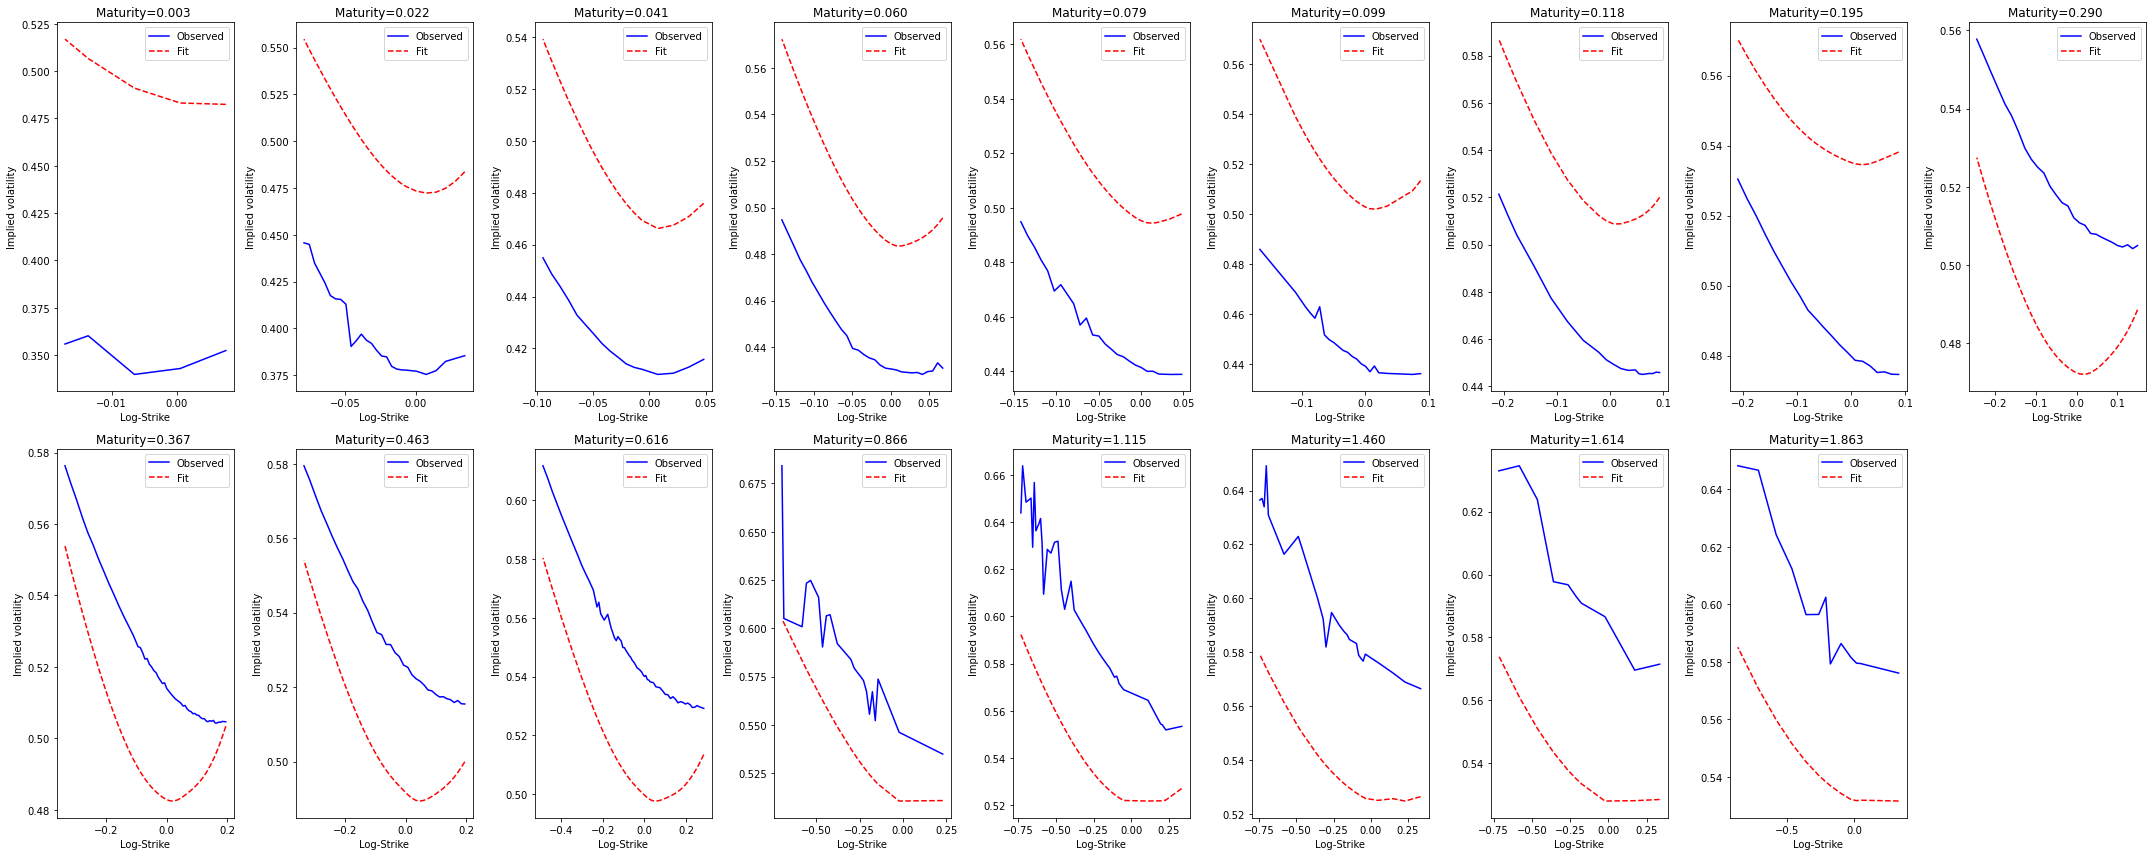

In [216]:
##### Plot the fit:
iv_fit = model.Eval(parCalib_fixed,k_obs,T_obs)

uniqT = np.unique(T_obs)
npts = 25
plt.figure(1,figsize=(30,12))
j = 0
iList = np.arange(0,len(uniqT))

if len(uniqT)%4 == 0:
    lines = 4
else:
    lines = 2
cols = len(uniqT)/lines


for i in iList:
    j = j + 1
    plt.subplot(lines,cols+1,j)
    idxT = T_obs == uniqT[i]
    plt.plot(k_obs[idxT],iv_obs[np.squeeze(idxT)],'b',label='Observed')
    plt.plot(k_obs[idxT],iv_fit[idxT],'--r',label='Fit')
    plt.title("Maturity=%1.3f "%uniqT[i])
    plt.xlabel("Log-Strike")
    plt.ylabel("Implied volatility")
    plt.legend()
plt.tight_layout()
plt.show()

In [217]:
import timeit
starttime = timeit.default_timer()
parCalib_list = list()
mse_sum = 0
for i, tau in enumerate(df_cleaned["Tau"].unique()):
    
    df_new = df_cleaned[df_cleaned["Tau"]==tau]
    ls_ = df_new["Log Strike"].values
    ttexp_ = df_new["Tau"].values
    mid_ = df_new["Mid"].values
    
    # Load example contracts:
    k_orig_ = np.transpose([ls_])# tmp[:,0].reshape(-1,1)
    T_orig_ = np.transpose([ttexp_])# tmp[:,1].reshape(-1,1)

    # Filter contracts that are not within the neural network domain:
    idxKeep = model.AreContractsInDomain(k_orig_,T_orig_)
    
    #print(len(idxKeep), len(k_orig), len(T_orig), len(mid))
    
    k_obs_ = np.flip(k_orig_[idxKeep,:])
    T_obs_ = np.flip(T_orig_[idxKeep,:])
    mid_obs = np.flip(mid_[idxKeep])
    #iv_obs_ = np.transpose([df_new["Mid IVs"].values])
    #iv_obs_ = iv_obs_[idxKeep]

    print("Original number of observations: ",len(k_orig_))
    print("After filtering:",len(k_obs_))
    # new
    iv_obs_ = np.flip(df_new["Mid IVs"].values[idxKeep])
    iv_obs_ = np.transpose([iv_obs_])

    # Parameters as in Benessen
    H_roemer = 0.1
    eta_roemer = 1.9
    rho_roemer = -0.15
    xi_roemer = 0.05
    parTrue = np.append(np.array([H_roemer,eta_roemer,rho_roemer]),(pow(xi_roemer,2))*np.ones((1,27))).reshape(30,1)

    # Calculating Implied Volatilites via Black Scholes, as TRUE Implied Volatilities
    #list of strikes after filtering
#     strikes_new = spot*np.exp(k_obs_)
#     iv_obs = vec_bsinv(mid_obs,spot,np.squeeze(strikes_new),T_obs_[0])
#     iv_obs = np.transpose([iv_obs])
#     #iv_obs = np.flip(iv_obs)

    # Calibrate the model to see if we can recover the parameters:
    # Remark: We simplify by forcing the forward variance curve flat. This also avoids an overparameterised model.
    from scipy.optimize import minimize

    # Set parameter bounds:
    # Remark: Optimizer occassionally goes beyond the specified bounds. Thus we make the bounds slightly more narrow.
    bounds = []
    eps = pow(10,-6) 
    for i in range(0,len(model.lb)):
        bounds.append([model.lb[i]+eps,model.ub[i]-eps])

    # Fix the forward variance curve flat:
    bounds = bounds[0:4]
    idxConvPar = np.concatenate((np.array([0,1,2]),3*np.ones(27))).astype(int)
    par0 = np.array([0.2,1.6,-0.7,pow(0.25,2)])

    # Define the error function:
    def err_fun(parEval):
        return(np.sum(pow(iv_obs_ - model.Eval(parEval[idxConvPar].reshape(-1,1),k_obs_,T_obs_),2)))

    # Optimize:
    bds = ([1.e-06, 0.750001, -0.999999, 0.002501], [0.499999, 3.499999, -1.e-06, 0.999999])
    res = minimize(err_fun,par0,method='L-BFGS-B',bounds=np.squeeze(bounds)) #minimize(err_fun,par0,method='L-BFGS-B',bounds=bounds)
    mse_sum = mse_sum + res.fun
    print("Optimisation message: ", res.message)
    parCalib = res.x[idxConvPar].reshape(-1,1)

    # Compare calibrated and true parameters:
    #print("[True , Calibrated]: ")
    #np.concatenate((parTrue,parCalib),1)
    parCalib_list = [*parCalib_list, parCalib]

print("Time taken for NN Calibration :", timeit.default_timer() - starttime)
print("Total MSE to the whole Surface is: {}".format(mse_sum))

Original number of observations:  63
After filtering: 5
Optimisation message:  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Original number of observations:  68
After filtering: 26
Optimisation message:  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Original number of observations:  65
After filtering: 17
Optimisation message:  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Original number of observations:  56
After filtering: 30
Optimisation message:  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Original number of observations:  30
After filtering: 24
Optimisation message:  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Original number of observations:  21
After filtering: 21
Optimisation message:  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Original number of observations:  184
After filtering: 20
Optimisation message:  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Original number of observations:  58
After filtering: 21
Optimisation message:  b'C

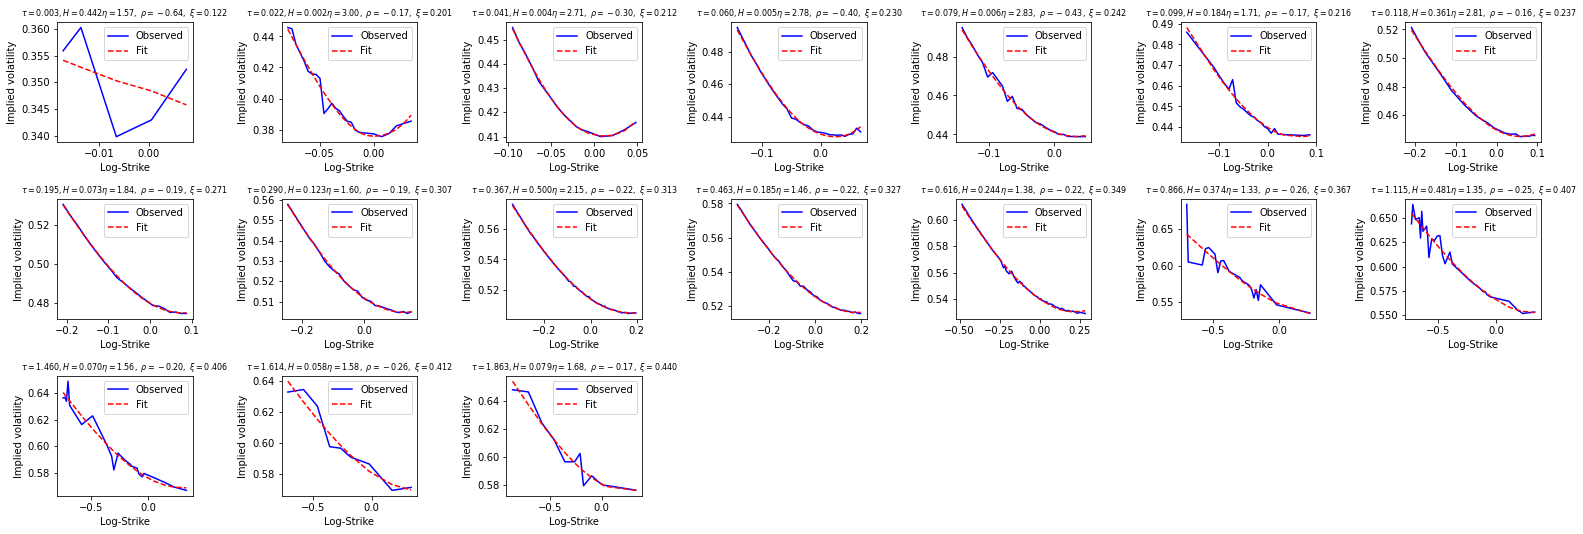

In [218]:
##### Plot the fit:
plt.figure(1,figsize=(22,12))
j = -1
for i, tau in enumerate(df_cleaned["Tau"].unique()):
    
    df_new = df_cleaned[df_cleaned["Tau"]==tau]
    ls_ = df_new["Log Strike"].values
    ttexp_ = df_new["Tau"].values
    mid_ = df_new["Mid"].values
    iv_obs_ = np.transpose([df_new["Mid IVs"].values])
    
    # Load example contracts:
    k_orig_ = np.transpose([ls_])# tmp[:,0].reshape(-1,1)
    T_orig_ = np.transpose([ttexp_])# tmp[:,1].reshape(-1,1)
    
    # Filter contracts that are not within the neural network domain:
    idxKeep = model.AreContractsInDomain(k_orig_,T_orig_)
    k_obs_ = (k_orig_[idxKeep,:])
    T_obs_ = (T_orig_[idxKeep,:])
    mid_obs_ = np.flip(mid_[idxKeep])
    
    iv_obs_ = iv_obs_[idxKeep]
    iv_fit_ = model.Eval(parCalib_list[i],k_obs_,T_obs_)

    j = j + 1
    plt.subplot(5,7,j+1)
    plt.plot(k_obs_,iv_obs_,'b',label='Observed')
    plt.plot(k_obs_,iv_fit_,'--r',label='Fit')
    
    title = r'$ \tau=%1.3f, H =%1.3f \eta=%.2f,\ \rho=%.2f,\ \xi=%.3f$' #\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f 
    plt.title(title%(tau, parCalib_list[i][0], parCalib_list[i][1], parCalib_list[i][2], parCalib_list[i][3]), fontsize=8)
    
    
    #plt.title("Maturity=%1.3f, Params =%1.3f  "%tau, %parCalib_list[i][:4])
    plt.xlabel("Log-Strike")
    plt.ylabel("Implied volatility")
    plt.legend()    
plt.tight_layout()
plt.show()

# uniqT = np.unique(T_obs)
# npts = 25
# plt.figure(1,figsize=(14,12))
# j = -1
# iList = np.arange(0,len(uniqT))
# for i in iList:
#     j = j + 1
#     plt.subplot(4,4,j+1)
#     idxT = T_obs == uniqT[i]
#     plt.plot(k_obs[idxT],iv_obs[idxT],'b',label='Observed')
#     plt.plot(k_obs[idxT],iv_fit[idxT],'--r',label='Fit')
#     plt.title("Maturity=%1.3f "%uniqT[i])
#     plt.xlabel("Log-Strike")
#     plt.ylabel("Implied volatility")
#     plt.legend()
# plt.tight_layout()
# plt.show()

In [219]:
# starting time
start = time.time()

# Calibrate the model to see if we can recover the parameters:
# Remark: We simplify by forcing the forward variance curve flat. This also avoids an overparameterised model.
from scipy.optimize import minimize

# Set parameter bounds:
# Remark: Optimizer occassionally goes beyond the specified bounds. Thus we make the bounds slightly more narrow.
bounds = []
eps = pow(10,-6) 
for i in range(0,len(model.lb)):
    bounds.append([model.lb[i]+eps,model.ub[i]-eps])
    
# Fix the forward variance curve flat:
#bounds = bounds[0:4]
bounds = bounds[3:]
idxConvPar = np.concatenate((np.array([0,1,2]),3*np.ones(27))).astype(int)


# floating forward variance  -------------------------------------------------------------------
# par0 is now only the forward variance curve, excluding any other parameter (like h, eta, rho)
par0 = np.squeeze(parCalib_fixed[3:]) #np.array([0.2,1.6,-0.7,pow(0.25,2)])
# Define the error function:
def err_fun(parEval):
    
    fixedparams = np.squeeze(parCalib_fixed)[:3]
    fixedparams = fixedparams.tolist()
    
    params1 = fixedparams
    params1.extend(parEval)
    params2 = np.array(params1)
    iv_nn = model.Eval(params2.reshape(-1,1),k_obs,T_obs)
    
    return(np.sum(pow(iv_obs - iv_nn,2)))

# Optimize:
bds = ([1.e-06, 0.750001, -0.999999, 0.002501], [0.499999, 3.499999, -1.e-06, 0.999999])
res = minimize(err_fun,par0,method='L-BFGS-B',bounds=np.squeeze(bounds)) #minimize(err_fun,par0,method='L-BFGS-B',bounds=bounds)
print("Optimisation message: ", res.message)
parCalib_fwdVar = res.x.reshape(-1,1)

# end time
end = time.time()
print(f"Runtime of the program is {end - start} seconds")

Optimisation message:  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Runtime of the program is 74.73298716545105 seconds


In [220]:
parCalib_floating = np.concatenate((np.squeeze(parCalib_fixed[:3]), np.squeeze(parCalib_fwdVar)), axis=0).reshape(-1,1)

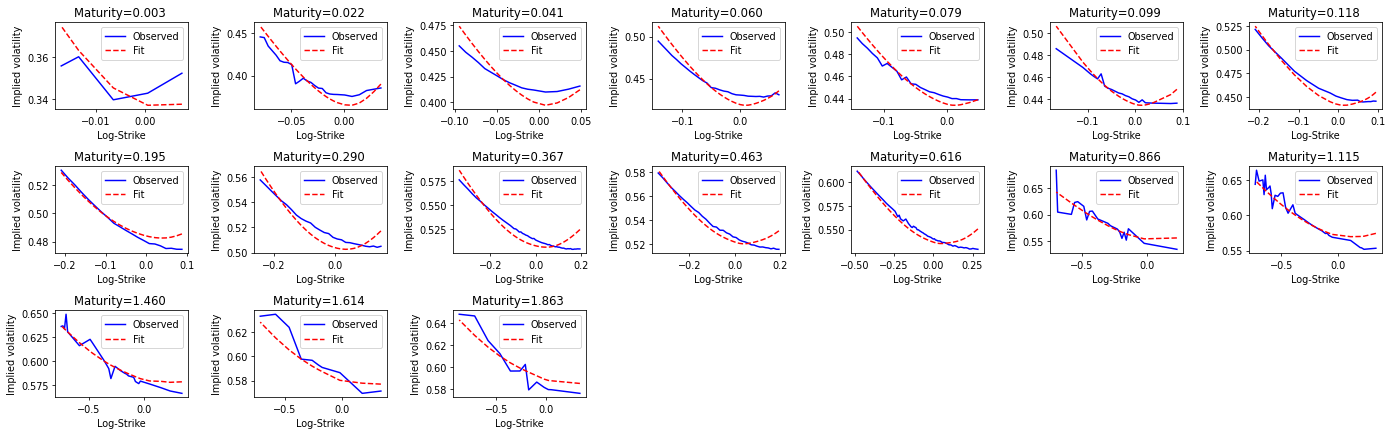

In [221]:
##### Plot the fit:
iv_fit = model.Eval(parCalib_floating,k_obs,T_obs)

uniqT = np.unique(T_obs)
npts = 25
plt.figure(1,figsize=(20,10), dpi=70)
j = 1
iList = np.arange(0,len(uniqT))
for i in iList:
    j = i+1
    plt.subplot(5,7,j)
    idxT = T_obs == uniqT[i]
    plt.plot(k_obs[idxT],iv_obs[idxT],'b',label='Observed')
    plt.plot(k_obs[idxT],iv_fit[idxT],'--r',label='Fit')
    plt.title("Maturity=%1.3f "%uniqT[i])
    plt.xlabel("Log-Strike")
    plt.ylabel("Implied volatility")
    plt.legend()
plt.tight_layout()
plt.savefig("Floating Forward Variance Curve")
plt.show()

In [105]:
len(uniqT)

18

In [ ]:
def str_to_float(value):
    try:
        return np.float(value)
    except ValueError as ve:
        print("value error: {}".format(ve))
        sepvals=value.split(",")
        fixed_val = np.float((sepvals[0])+(sepvals[1]))
        return fixed_val
        
    except Exception as e:
        print("Normal exception: {}".format(e))
        pass

In [ ]:
from requests_html import HTMLSession

def str_to_float(value):
    try:
        return np.float(value)
    except Exception as e:
        print(e)
        pass

def get_earnings_data(ticker):
    
    # Parse yahoo finance & scrape earnings data
    url = "https://finance.yahoo.com/calendar/earnings?symbol={}".format(ticker)
    session = HTMLSession()
    resp = session.get(url)
    html = resp.html.raw_html.decode()
    earnings_table = pd.read_html(html)[0]
    
    # Convert Data to readable format
    reported_values = [str_to_float(x) for x in earnings_table["Reported EPS"]]
    estimated_values = [str_to_float(x) for x in earnings_table["EPS Estimate"]]
    surprise_values = [str_to_float(x) for x in earnings_table["Surprise(%)"]]
    str_earnings = "%b %d, %Y, %I %p"
    datetime_data = [datetime.strptime(x[:-3], str_earnings) for x in earnings_table["Earnings Date"]]
    earnings_table["Reported EPS"] = reported_values
    earnings_table["EPS Estimate"] = estimated_values    
    earnings_table["Surprise(%)"] = surprise_values 
    earnings_table["Earnings Date"] = datetime_data
    return earnings_table

def price_div_hist_fun(ticker, date_str):
    # define ticker and get data
    ticker_object = yf.Ticker(ticker)
    price_div_hist = ticker_object.history(start='2010-01-01')
    # get spot
    close_price = price_hist['Close']
    spot = float(close_price[close_price.index==date_str])
    return spot, price_div_hist
    
def dividend_estimation(ticker, year, date_str):
    
    earnings_table = get_earnings_data(ticker)
    spot, price_div_hist = price_div_hist_fun(ticker, date_str)
    
    # Specify time range of dividend payments
    
    # calculate dividend payout ratio
    earnings_table_year = earnings_table[ ( earnings_table["Earnings Date"]> str(year)) & ( earnings_table["Earnings Date"] < str(year+1)) ]
    price_div_hist_year = price_div_hist[(price_div_hist.index > str(year)) & (price_div_hist.index < str(year+1))]
    
    cum_earnings = earnings_table_year["Reported EPS"].sum()
    cum_dividends = price_div_hist_year["Dividends"].sum()

    dividend_payout_ratio = cum_dividends/cum_earnings
        
    # unique years
    data = df_all_maturities["Maturity"]
    str_mat = "%B %d, %Y"
    list1 = [datetime.strptime(x, str_mat) for x in data]
    unique_years = set([x.year for x in list1])
    
    # Projected Dividends
    projected_earnings = earnings_table[earnings_table["Earnings Date"]>str(year+1)]
    projected_dividends = projected_earnings["EPS Estimate"]*dividend_payout_ratio
    projected_earnings["Div Estimate"] = projected_dividends
    
    # combining past and projected dividends
    div_hist_df = pd.DataFrame(index=price_div_hist.index)
    div_hist_df["Dividends"] = price_div_hist.Dividends
    div_est_df = pd.DataFrame(index=projected_earnings["Earnings Date"])
    div_est_df["Dividends"] = projected_earnings["Div Estimate"].values
    all_div_df = pd.concat([div_hist_df, div_est_df])
    
    return all_div_df
    
def find_pv_dividends(date_str, df_all_maturities, all_div_df, r):
    str_today = "%Y-%m-%d"
    today_dt = datetime.strptime(date_str, str_today)
    pv_dividend_list = list()

    for index0, row0 in df_all_maturities.iterrows():
        # Finding all (dividend) dates between time of observation and option chain maturity! 
        data_df = all_div_df[ (all_div_df.index > date_str) & (all_div_df.index < row0["Maturity"]) ]
        data_df["PV_dividends"] = np.zeros(len(data_df.index))

        # If no dividend payments fall within timeframe, do nothing
        div_sum = data_df.values.sum()
        if div_sum == 0: 
            sum_pv_dividends = 0
        # if there are dividend payments...
        else:
            # for each dividend payment
            for index, row in data_df.iterrows():
                divPayment = row["Dividends"]

                if not divPayment == 0:

                    time_in_years = (index - today_dt).days/252

                    row["PV_dividends"] = divPayment * np.exp(-r*time_in_years)

        sum_pv_dividends = data_df["PV_dividends"].sum()
        pv_dividend_list.append(sum_pv_dividends)
    df_all_maturities["PV Dividends"] = pv_dividend_list
    return df_all_maturities
            
df_all_maturities = find_pv_dividends(date_str, df_all_maturities, all_div_df, r)   

In [ ]:
# Discounting dividends payments


r=0.001

def find_pv_dividends(date_str, df_all_maturities, all_div_df, r):
    str_today = "%Y-%m-%d"
    today_dt = datetime.strptime(date_str, str_today)
    pv_dividend_list = list()

    for index0, row0 in df_all_maturities.iterrows():
        # Finding all (dividend) dates between time of observation and option chain maturity! 
        data_df = all_div_df[ (all_div_df.index > date_str) & (all_div_df.index < row0["Maturity"]) ]
        data_df["PV_dividends"] = np.zeros(len(data_df.index))

        # If no dividend payments fall within timeframe, do nothing
        div_sum = data_df.values.sum()
        if div_sum == 0: 
            sum_pv_dividends = 0
        # if there are dividend payments...
        else:
            # for each dividend payment
            for index, row in data_df.iterrows():
                divPayment = row["Dividends"]

                if not divPayment == 0:

                    time_in_years = (index - today_dt).days/252

                    row["PV_dividends"] = divPayment * np.exp(-r*time_in_years)

        sum_pv_dividends = data_df["PV_dividends"].sum()
        pv_dividend_list.append(sum_pv_dividends)
    df_all_maturities["PV Dividends"] = pv_dividend_list
    return df_all_maturities
            
df_all_maturities = find_pv_dividends(date_str, df_all_maturities, all_div_df, r)        